In [12]:
#! pip install torch transformers seaborn scikit-learn pandas

In [1]:
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm

from styles import fig_size

palette = sns.color_palette('Set2')
sns.set_style('white')
sns.set_context('talk')
sns.set_palette(palette=palette)

In [3]:
ner_models = [
    #'flair',
    'dslim/bert-base-NER',
    'dslim/bert-large-NER'
]

In [47]:
# ONS baby names 2021
df1 = pd.read_csv('data/baby_name_counts.csv')
df2 = pd.read_csv('data/baby_names.csv')
df = df2.join(df1)
df = df.dropna()
df


,Name,Counts
0,A,5.0
1,A-Jay,5.0
3,Aaban,4.0
5,Aadam,90.0
8,Aaden,5.0
...,...,...
16763,Zy'Aire,3.0
16767,Zyair,4.0
16768,Zyaire,14.0
16769,Zyan,19.0


# rank-counts of baby names in UK 2021

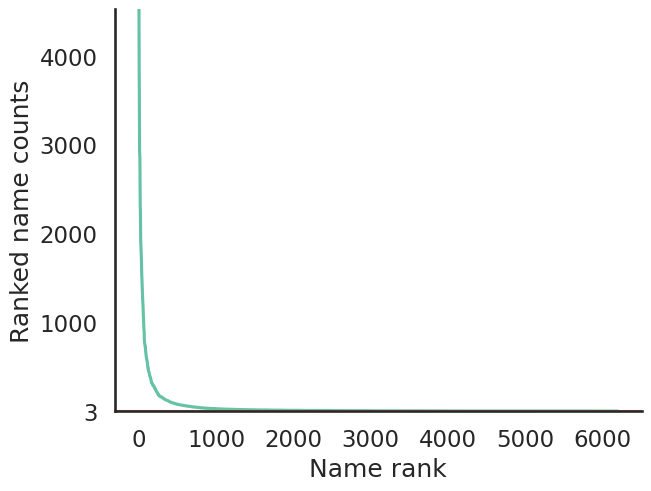

In [74]:
df_s = df.sort_values('Counts', ascending=False)

x = np.arange(len(df_s))
y = df_s.Counts.to_numpy()# / df_s.Counts.sum()
y2 = np.cumsum(y)


plt.figure(constrained_layout=True)
#add first line to plot
ax = sns.lineplot(x=x, y=y)
sns.despine()
ax.set_ylabel('Ranked name counts')
ax.set_xlabel('Name rank')
ax.axhline(0, color=palette[1])
ax.set_ylim(3, np.max(y))
ax.set_yticks([3, 1000, 2000, 3000, 4000])

plt.savefig('figures/name_counts.png', dpi=300)

plt.show()


# Create baby names 2021 population

In [16]:
names = []
counts = {}
for i, row in df.iterrows():
    names_i = [row['Name']] * int(row['Counts'])
    names += names_i
    counts[row['Name']] = row['Counts']


In [48]:
def name_sample(names, n=100):
    names_cp = copy.copy(names)
    rng = np.random.default_rng(seed=0)
    rng.shuffle(names_cp)
    names_i = rng.choice(names_cp, n)

    sample_data = {
        'Name': [],
        'Count': [],
        'Population Percentage': []
    }

    for name in names_i:
        sample_data['Name'].append(name)
        sample_data['Count'].append(counts[name])
        sample_data['Population Percentage'].append(counts[name] / len(names))


    df_sample = pd.DataFrame(data=sample_data)
    df_sample['Count'] = df_sample['Count'].astype('int')
    return df_sample

df_sample = name_sample(names, 100)
k = 5
top_k = df_sample.sort_values('Count').reset_index(drop=True)[:k]
top_k


,Name,Count,Population Percentage
0,Saahil,5,0.000017
1,Majed,5,0.000017
2,Anthony-James,5,0.000017
3,Nihan,8,0.000027
4,Rashid,12,0.000041


In [49]:
tex =  top_k.to_latex(
    index=False,
    float_format="{:.2E}".format,
    caption='Top 5 rarest names appearing in a random sample of UK baby names in 2021')
print(tex)

\begin{table}
\caption{Top 5 rarest names appearing in a random sample of UK baby names in 2021}
\begin{tabular}{lrr}
\toprule
Name & Count & Population Percentage \\
\midrule
Saahil & 5 & 1.69E-05 \\
Majed & 5 & 1.69E-05 \\
Anthony-James & 5 & 1.69E-05 \\
Nihan & 8 & 2.71E-05 \\
Rashid & 12 & 4.07E-05 \\
\bottomrule
\end{tabular}
\end{table}



In [4]:
ner_models = [
    #'flair',
    'dslim/bert-base-NER',
    'dslim/bert-large-NER'
]

# Failure rates of most common NER models on Huggingface

In [20]:
print(names[:10], len(names))

n = 100000



y_preds = []
test_names = []
models = []
acc = []

df_sample = name_sample(names, n=n)

print(df_sample)
print(df_sample.dtypes)

for model_name in ner_models:

    if 'flair' in model_name:
        
        y_pred_i = []

        names_i = np.unique(df_sample.Name)

        for name in tqdm(names_i):
            print('hi')
            sentence = Sentence(f"Good morning {name} how can i help you?")

            # load the NER tagger
            tagger = Classifier.load('ner-large')

            # run NER over sentence
            tagger.predict(sentence)

            # print the sentence with all annotations
            print(sentence)
            print(type(sentence))

    else:

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForTokenClassification.from_pretrained(model_name)

        y_pred_i = []

        df_sample = name_sample(names, n=n)

        names_i = np.unique(df_sample.Name)

        for name in tqdm(names_i):

            nlp = pipeline("ner", model=model, tokenizer=tokenizer)
            example = f"Good morning {name} how can i help you?"

            ner_results = nlp(example)

            # if no response
            if not ner_results:
                y_pred_i.append(0)
                continue

            # log 1 if a name was found.
            y_pred_j = 0
            for item in ner_results:
                # https://huggingface.co/dslim/bert-base-NER
                if item['entity'] in ['B-PER', 'I-PER', 'PER'] and item['index'] == 3:
                    y_pred_j = 1
            
            y_pred_i.append(y_pred_j)

    assert len(y_pred_i) == len(names_i)

    y_true = np.ones(len(names_i))
    acc_i = 1 - accuracy_score(y_true, y_pred_i)
    acc.append(acc_i)
    y_preds.append(y_pred_i)
    print(y_preds)
    test_names.append(names_i)
    models.append([model_name] * len(names_i))
    print(f'{model_name} Failure score {acc_i:.2f}')


df_ner = pd.DataFrame(data={
    'Name': np.concatenate(test_names, axis=0),
    'y_pred': np.concatenate(y_preds, axis=0),
    'model': np.concatenate(models, axis=0)
})

df_ner = df_ner.merge(df_sample, on='Name', how='left')

df_ner.to_csv('data/ner_deep_learning_results.csv')

print(list(zip(ner_models, acc)))


['A', 'A', 'A', 'A', 'A', 'A-Jay', 'A-Jay', 'A-Jay', 'A-Jay', 'A-Jay'] 295057
           Name  Count  Population Percentage
0          Theo   2514               0.008520
1          Otis    737               0.002498
2      Nicholas    321               0.001088
3      Muhammad   3722               0.012615
4         Wyatt    156               0.000529
...         ...    ...                    ...
99995     Kobie     80               0.000271
99996     Lucas   1965               0.006660
99997      Noah   4525               0.015336
99998    Arthur   3766               0.012764
99999     Teddy   1875               0.006355

[100000 rows x 3 columns]
Name                      object
Count                      int64
Population Percentage    float64
dtype: object


 10%|█         | 545/5284 [00:15<02:17, 34.57it/s]


KeyboardInterrupt: 

# PLot

model dslim/bert-base-NER ttest
TtestResult(statistic=-32.86058492011357, pvalue=7.304945319624171e-236, df=99998.0)
model dslim/bert-large-NER ttest
TtestResult(statistic=-21.791424467634638, pvalue=2.45994387495394e-105, df=99998.0)


/home/john/anaconda3/envs/raiit-2023/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

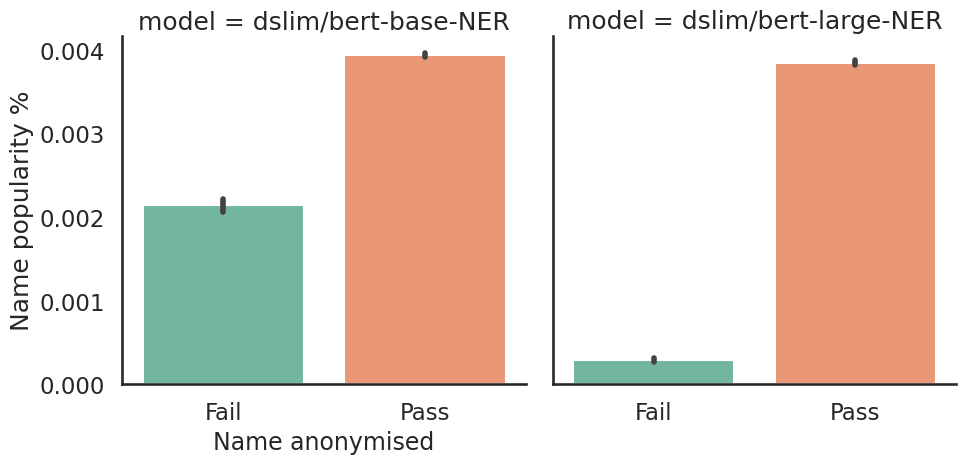

y_pred  model               
Fail    dslim/bert-base-NER      6166
        dslim/bert-large-NER      653
Pass    dslim/bert-base-NER     93834
        dslim/bert-large-NER    99347
Name: y_pred, dtype: int64

In [5]:
results_df = pd.read_csv('data/ner_deep_learning_results.csv')

from scipy.stats import ttest_ind

for model in ner_models:
    results_df['y_pred'] = results_df['y_pred'].astype(int)
    a = results_df[(results_df['y_pred'] == 0) & (results_df['model'] == model)]['Population Percentage'].to_numpy()
    b = results_df[(results_df['y_pred'] == 1) & (results_df['model'] == model)]['Population Percentage'].to_numpy()
    print(f'model {model} ttest')
    r = ttest_ind(a, b, alternative='less')
    print(r)

results_df['y_pred'] = results_df['y_pred'].replace(1, 'Pass')
results_df['y_pred'] = results_df['y_pred'].replace(0, 'Fail')

results_df2 = results_df.copy()
#results_df2['model'] = results_df2['model'].replace('dslim/bert-base-NER', 'BERT-base')
#results_df2['model'] = results_df2['model'].replace('dslim/bert-large-NER', 'BERT-large')

plt.figure(figsize=(8, 4), constrained_layout=True)
s = sns.catplot(data=results_df2, x="y_pred", y="Population Percentage", col='model', kind='bar')

for ax in s.axes.flatten():
    ax.set_xlabel('', fontsize=15)

s.axes.flatten()[0].set_xlabel('Name anonymised', fontsize=17)
s.set_ylabels('Name popularity %')
sns.despine()
plt.savefig('figures/ner.pdf')
plt.savefig('figures/ner.png', dpi=330)

plt.show()

x = results_df.groupby('y_pred')["Population Percentage"].mean()

results_df3 = results_df2.groupby(['y_pred', 'model'])['y_pred'].count()
results_df3


,firstname,whi,bla,his,asi,oth
0,A,0.729594,0.210716,0.019178,0.021335,0.019178
1,AABIDA,0.000000,0.000000,0.000000,0.560000,0.440000
2,AADAM,0.160714,0.428571,0.000000,0.250000,0.160714
3,AADIL,0.109375,0.226562,0.000000,0.578125,0.085938
4,AADITYA,0.000000,0.000000,0.000000,0.812500,0.187500
...,...,...,...,...,...,...
135772,ZYSHAWN,0.000000,1.000000,0.000000,0.000000,0.000000
135773,ZYSHONNE,0.000000,1.000000,0.000000,0.000000,0.000000
135774,ZYTAVIOUS,0.000000,1.000000,0.000000,0.000000,0.000000
135775,ZYTERIA,0.000000,1.000000,0.000000,0.000000,0.000000


,firstname,whi,bla,his,asi,oth
0,A,0.729594,0.210716,0.019178,0.021335,0.019178
1,AABIDA,0.000000,0.000000,0.000000,0.560000,0.440000
2,AADAM,0.160714,0.428571,0.000000,0.250000,0.160714
3,AADIL,0.109375,0.226562,0.000000,0.578125,0.085938
4,AADITYA,0.000000,0.000000,0.000000,0.812500,0.187500
...,...,...,...,...,...,...
135772,ZYSHAWN,0.000000,1.000000,0.000000,0.000000,0.000000
135773,ZYSHONNE,0.000000,1.000000,0.000000,0.000000,0.000000
135774,ZYTAVIOUS,0.000000,1.000000,0.000000,0.000000,0.000000
135775,ZYTERIA,0.000000,1.000000,0.000000,0.000000,0.000000


{'whi': 'White', 'bla': 'Black', 'his': 'Hispanic', 'asi': 'Asian', 'oth': 'Other'}


,prob,ethnicity,NER detection
0,0.160714,White,Detected
1,0.109375,White,Detected
2,0.000000,White,Detected
3,0.022831,White,Detected
4,0.000000,White,Detected
...,...,...,...
38555,0.068670,Other,Ref
38556,0.050119,Other,Ref
38557,0.041667,Other,Ref
38558,0.047297,Other,Ref


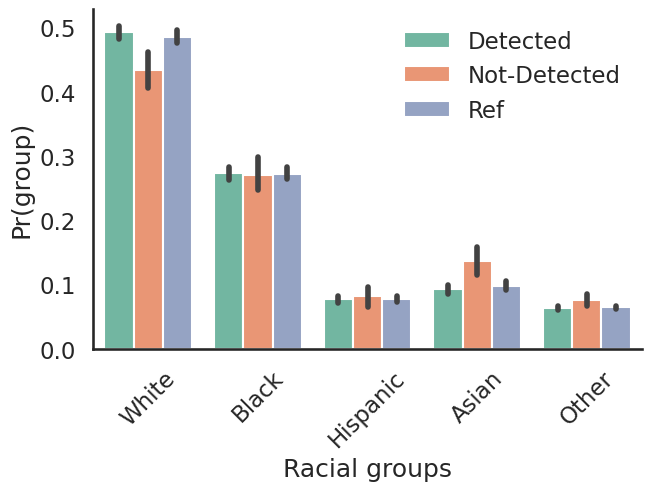

In [13]:
df_mistakes = pd.DataFrame({
    'firstname': results_df[(results_df['y_pred'] == 'Fail') & (results_df['model'] == 'dslim/bert-base-NER')]['Name'].unique()
})

df_correct = pd.DataFrame({
    'firstname': results_df[(results_df['y_pred'] == 'Pass') & (results_df['model'] == 'dslim/bert-base-NER')]['Name'].unique()
})

df_ref = pd.DataFrame({
    'firstname': results_df[results_df['model'] == 'dslim/bert-base-NER']['Name'].unique()
})

df_correct['firstname'] = df_correct['firstname'].str.upper()
df_mistakes['firstname'] = df_mistakes['firstname'].str.upper()
df_ref['firstname'] = df_ref['firstname'].str.upper()



#ethnicity_estimates = pd.read_csv('data/firstnames.csv')
ethnicity_estimates = pd.read_csv('data/first_nameRaceProbs.csv')
display(ethnicity_estimates)


# mistakes

# https://github.com/appeler/ethnicolr/blob/master/ethnicolr/data/census/census_2000.pdf
# page 17

#groups = [
#    'pcthispanic', # percent hispanic origin
#    'pctwhite', # percent non-hispanic white only
#    'pctblack', # perecnet non-hispanic black only
#    'pctapi', # Percent non-hispanic Asian and pacific islander only
#    'pctaian', # Percent non-hispanic american indian and alaskan native only
#    'pct2prace' # Percent non-hispanic of two or more races
#]

groups = ['whi','bla','his','asi','oth']

display(ethnicity_estimates)

df_mistake_ethnicity = df_mistakes.merge(ethnicity_estimates, on='firstname', how='inner')

df_ref_ethnicity = df_correct.merge(ethnicity_estimates, on='firstname', how='inner')

df_reference = df_ref.merge(ethnicity_estimates, on='firstname', how='inner')


probs = [df_mistake_ethnicity[group] for group in groups]
ethnicity = [[group] * len(df_mistake_ethnicity[group]) for group in groups]
probs = np.concatenate(probs, axis=0)
ethnicity = np.concatenate(ethnicity, axis=0)

df_prob = pd.DataFrame({
    'prob': probs,
    'ethnicity': ethnicity,
    'NER detection': ['Not-Detected'] * len(probs)
})

# general
probs = [df_ref_ethnicity[group] for group in groups]
ethnicity = [[group] * len(df_ref_ethnicity[group]) for group in groups]
probs = np.concatenate(probs, axis=0)
ethnicity = np.concatenate(ethnicity, axis=0)

df_prob_pop = pd.DataFrame({
    'prob': probs,
    'ethnicity': ethnicity,
    'NER detection': ['Detected'] * len(probs)
})

# general
probs = [df_reference[group] for group in groups]
ethnicity = [[group] * len(df_reference[group]) for group in groups]
probs = np.concatenate(probs, axis=0)
ethnicity = np.concatenate(ethnicity, axis=0)

df_prob_ref = pd.DataFrame({
    'prob': probs,
    'ethnicity': ethnicity,
    'NER detection': ['Ref'] * len(probs)
})

df_sets = pd.concat([df_prob_pop, df_prob, df_prob_ref]).reset_index(drop=True)

plt.figure(constrained_layout=True)
group_map = dict(zip(['whi','bla','his','asi','oth'], ['White', 'Black', 'Hispanic', 'Asian', 'Other']))
print(group_map)

df_sets = df_sets.replace(group_map)
display(df_sets)


ax = sns.barplot(data=df_sets, y='prob', x='ethnicity', hue='NER detection')
plt.xticks(rotation=45)
plt.xlabel('Racial groups')
plt.ylabel(r'Pr(group)')
plt.legend(frameon=False)
sns.despine()
plt.savefig('figures/raceethnic-bias.pdf')
plt.savefig('figures/raceethnic-bias.png', dpi=330)

plt.show()
